In [129]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt

In [27]:
os.environ['PTNONINTERACTIVE'] = '1'  # suppress messages from analysator
sys.path.insert(0, 'analysator')
from analysator import pytools as pt
from juliacall import Main as jl
jl.seval("using Vlasiator")

In [28]:
from analysator.pyPlots.plot_vdf import verifyCellWithVspace

In [205]:
filename = 'data/bulk.0000001.vlsv'

In [206]:
#del os.environ['PTNONINTERACTIVE']
f = pt.vlsvfile.VlsvReader(file_name=filename)

Found population proton


In [208]:
f.list()
m = f.get_spatial_mesh_size()
print(m)
a = f.read_variable("CellID")
print(a)
print(len(a))
t = f.read_parameter('time')
print(f't = {t}')
idx = f.read_parameter('fileIndex')
print(f'fileIndex = {idx}')


tag = PARAMETER
    time
    dt
    timestep
    fieldSolverSubcycles
    fileIndex
    xmin
    xmax
    ymin
    ymax
    zmin
    zmax
    xcells_ini
    ycells_ini
    zcells_ini
    version
    numWritingRanks
tag = VARIABLE
    CellID
    fg_b
    fg_e
    proton/vg_blocks
    proton/vg_rho_nonthermal
    proton/vg_v_nonthermal
    proton/vg_ptensor_nonthermal_diagonal
    proton/vg_ptensor_nonthermal_offdiagonal
    proton/vg_rho_thermal
    proton/vg_v_thermal
    proton/vg_ptensor_thermal_diagonal
    proton/vg_ptensor_thermal_offdiagonal
    proton/vg_ptensor_diagonal
    proton/vg_ptensor_offdiagonal
    proton/vg_rho
    proton/vg_v
    vg_b_vol
    vg_boundarytype
    vg_f_saved
    vg_rank
[1200    1    1]
[ 11  10   9 ... 850 851 858]
1200
t = 10.027748691099463
fileIndex = 1




cellid 1, x = -149925000.0, y = 0.0, z = 0.0
Input velocity grid cell size 30000.0
Getting offsets for population proton
Found 750208 v-space cells
Warning! Unable to find a MinValue or EffectiveSparsityThreshold value from the .vlsv file.
Using a default value of 1.e-16. Override with setThreshold=value.
Dropping velocity cells under setThreshold value 1e-16
Projecting total VDF to a single plane
Active f range is 9.181953544104117e-15 to 1.4885531391979247e-10
plots/plot_vdf_proton_cellid_1_t0_xz_proj.png



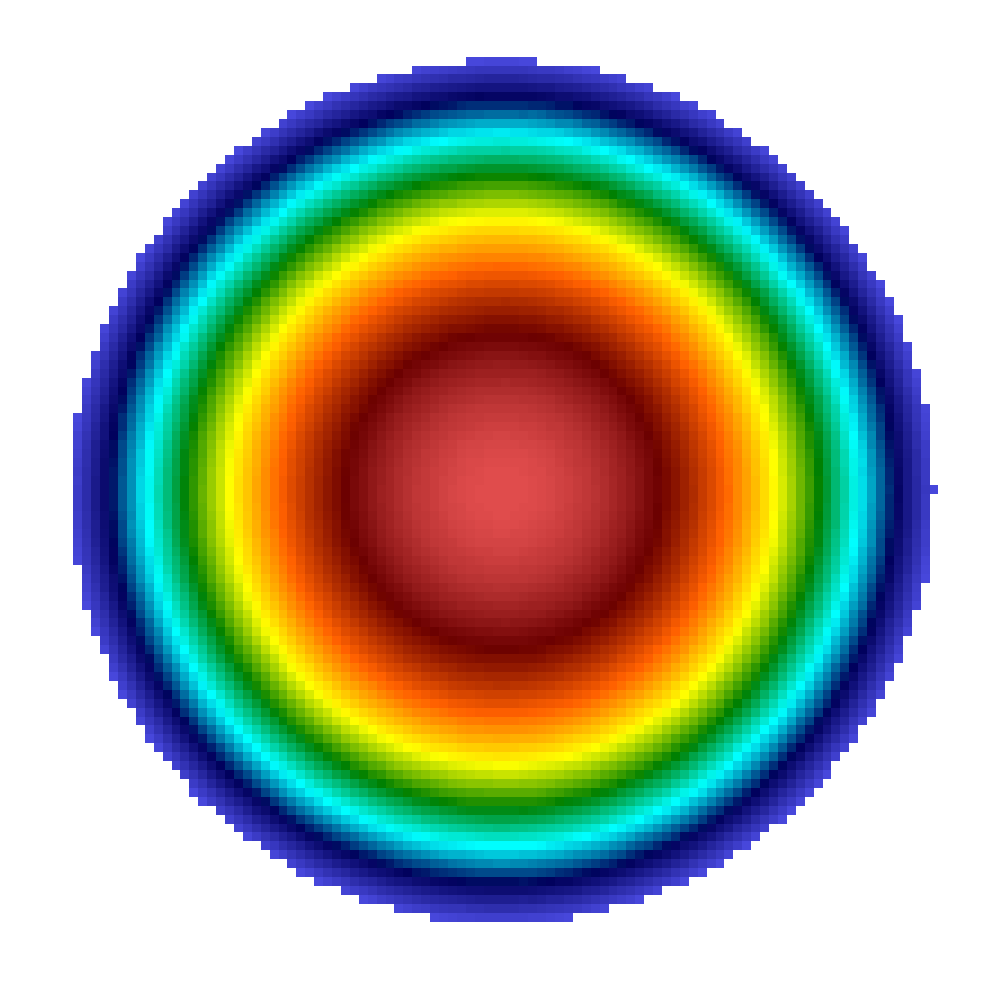

In [32]:
pt.plot.plot_vdf(
    vlsvobj=f, 
    cellids=[1],
    outputdir="plots/",
    slicethick=0, 
    thick=0, 
    scale=0, 
    noborder=1, 
    noxlabels=1, 
    noylabels=1, 
    nocb=1, 
    title=""
)

In [33]:
data_filenames = glob.glob('data/*.vlsv')

In [34]:
cell_ids = f.read_variable('CellID')

In [35]:
#for id in cell_ids:
#    if verifyCellWithVspace(f, id):
#        print(id)
cells_with_vdf = [id for id in cell_ids if verifyCellWithVspace(f, id)]
print(cells_with_vdf)

[1, 26, 51, 76, 101, 126, 151, 226, 251, 176, 301, 276, 351, 376, 401, 201, 476, 501, 451, 551, 326, 626, 651, 576, 701, 751, 776, 801, 426, 876, 901, 951, 826, 1051, 1076, 1001, 1151, 1026, 1176, 1101, 1126, 526, 601, 676, 926, 726, 976, 851]


In [36]:
meta = jl.load(data_filenames[15])

In [37]:
vcellids, vcellf = jl.readvcells(meta, 1101, species="proton")

In [38]:
flat = np.array(jl.Vlasiator.flatten(meta.meshes["proton"], vcellids, vcellf), dtype=np.float64)

In [39]:
print(len(flat))
print(flat.shape)
r = flat[269, 269, :]
print(sum(r != 0))
print(np.argmax(r))

536
(536, 536, 536)
24
276


In [40]:
a = np.array(flat, dtype=np.float64)

In [41]:
r = np.array(r)

In [42]:
#r = r / np.max(r)
print(r[200:260])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


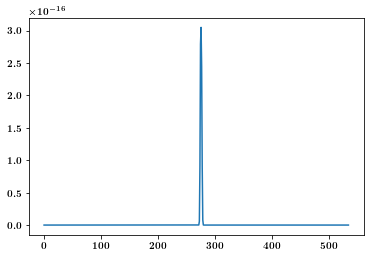

In [43]:
plt.plot(r)

In [44]:
np.unravel_index(np.argmax(flat), flat.shape)

(242, 268, 224)

In [45]:
def transform_f(data):
    data = np.abs(data)
    data = np.cbrt(data) # square root transform to enhance the more distant parts
    #data = data / np.max(data)
    return data

In [46]:
def find_peak_f_coordinates(data):
    return np.unravel_index(np.argmax(data), data.shape)

In [47]:
# https://stackoverflow.com/a/26127012/287954
def fibonacci_sphere(samples=1000):
    points = np.empty((samples, 3))
    phi = np.pi * (3 - 5 ** 0.5)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = (1 - y * y) ** 0.5  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        points[i] = np.array([x, y, z])

    return points

In [48]:
def generate_spheres(center, n_spheres, n_points, r, distribution='radius'):
    radii = np.linspace(r / n_spheres, r, n_spheres)
    if distribution == 'area':
        areas = 4 * np.pi * radii ** 2
        a_tot = np.sum(areas)
        points_per_sphere = np.trunc((areas / a_tot) * n_points).astype(int)
        points_per_sphere[:n_points - np.sum(points_per_sphere)] += 1
    elif distribution == 'radius':
        points_per_sphere = np.trunc((radii / np.sum(radii)) * n_points).astype(int)
        points_per_sphere[:n_points - np.sum(points_per_sphere)] += 1
    elif distribution == 'even':
        points_per_sphere = np.ones(n_spheres) * (n_points // n_spheres)
        points_per_sphere[-(n_points - np.sum(points_per_sphere)):] += 1
    else:
        raise ValueError(f'Unknown distribution {distribution}')
    spheres = []
    for n, radius in zip(points_per_sphere, radii):
        s = np.array(radius * fibonacci_sphere(n)) + center
        spheres.append(np.trunc(s).astype(int))
    return spheres

In [49]:
f = transform_f(flat)

In [50]:
center = find_peak_f_coordinates(f)
s = generate_spheres(center, n_spheres=25, n_points=100000, r=90, distribution='radius')

In [51]:
def sample_sphere(f, sphere):
    return f[sphere[:, 0], sphere[:, 1], sphere[:, 2]]

In [52]:
def sample_f(f, spheres):
    res = {}
    for i, s in enumerate(spheres):
        sample = sample_sphere(f, s)
        res[f's{i}_min'] = np.min(sample)
        res[f's{i}_max'] = np.max(sample)
        res[f's{i}_mean'] = np.mean(sample)
        res[f's{i}_median'] = np.median(sample)
        res[f's{i}_var'] = np.var(sample)
        res[f's{i}_skew'] = scs.skew(sample)
        res[f's{i}_kurt'] = scs.kurtosis(sample)
        res[f's{i}_zeros'] = np.sum(sample == 0) / len(sample)
    return res

In [53]:
def sample_vlsv(filename, spheres):
    ret_df = None
    f = pt.vlsvfile.VlsvReader(file_name=filename)
    cell_ids = f.read_variable('cellid')
    cells_with_vdf = [int(id) for id in cell_ids if verifyCellWithVspace(f, id)]
    print(cells_with_vdf)
    meta = jl.load(filename)
    for cell in cells_with_vdf:
        print(f'processing cell {cell}')
        vcellids, vcellf = jl.readvcells(meta, cell, species="proton")
        f = np.array(jl.Vlasiator.flatten(meta.meshes["proton"], vcellids, vcellf), dtype=np.float64)
        f = transform_f(f)
        row = pd.DataFrame([{'id': cell} | sample_f(f, spheres)])
        if ret_df is None:
            ret_df = row
        else:
            ret_df = pd.concat([ret_df, row])
    return ret_df

In [61]:
df = None
for filename in data_filenames:
    print(f'processing {filename}')
    rows = sample_vlsv(filename, s)
    if df is None:
        df = rows
    else:
        df = pd.concat([df, rows])
df.to_csv('plots/spheres.csv')
df

processing data\bulk.0000000.vlsv
[1, 26, 51, 76, 101, 126, 151, 226, 251, 176, 301, 276, 351, 376, 401, 201, 476, 501, 451, 551, 326, 626, 651, 576, 701, 751, 776, 801, 426, 876, 901, 951, 826, 1051, 1076, 1001, 1151, 1026, 1176, 1101, 1126, 526, 601, 676, 926, 726, 976, 851]
processing cell 1
processing cell 26
processing cell 51
processing cell 76
processing cell 101
processing cell 126
processing cell 151
processing cell 226
processing cell 251
processing cell 176
processing cell 301
processing cell 276
processing cell 351
processing cell 376
processing cell 401
processing cell 201
processing cell 476
processing cell 501
processing cell 451
processing cell 551
processing cell 326
processing cell 626
processing cell 651
processing cell 576
processing cell 701
processing cell 751
processing cell 776
processing cell 801
processing cell 426
processing cell 876
processing cell 901
processing cell 951
processing cell 826
processing cell 1051
processing cell 1076
processing cell 1001
proc

,id,s0_min,s0_max,s0_mean,s0_median,s0_var,s0_skew,s0_kurt,s0_zeros,s1_min,...,s23_kurt,s23_zeros,s24_min,s24_max,s24_mean,s24_median,s24_var,s24_skew,s24_kurt,s24_zeros
0,1,0.511420,0.748320,0.623441,0.632943,0.004868,0.137050,-1.082217,0.0,0.385425,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,26,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,51,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,76,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,101,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,126,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,151,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,226,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,251,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,176,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0


In [62]:
df = pd.read_csv('plots/spheres.csv', index_col=0)
df

,id,s0_min,s0_max,s0_mean,s0_median,s0_var,s0_skew,s0_kurt,s0_zeros,s1_min,...,s23_kurt,s23_zeros,s24_min,s24_max,s24_mean,s24_median,s24_var,s24_skew,s24_kurt,s24_zeros
0,1,0.511420,0.748320,0.623441,0.632943,0.004868,0.137050,-1.082217,0.0,0.385425,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,26,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,51,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,76,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,101,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,126,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,151,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,226,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,251,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0
0,176,0.511426,0.748449,0.623444,0.632947,0.004868,0.136805,-1.082462,0.0,0.385294,...,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0


In [56]:
def generate_features(row):
    means = []
    zeros = 0
    partials = 0
    gap = None
    for n in range(25):
        means.append(row[f's{n}_mean'])
        zeros += 1 if row[f's{n}_zeros'] == 1 else 0
        if row[f's{n}_zeros'] > 0 and row[f's{n}_zeros'] < 1:
            partials += 1
        if row[f's{n}_zeros'] == 1 and gap is None:
            gap = 0
        elif row[f's{n}_zeros'] != 1 and gap == 0:
            gap = 1
    if gap is None:
        gap = 0
    row['gap'] = gap
    row['mean'] = np.mean(means)
    row['zeros'] = zeros / 25
    row['partials'] = partials / 25
    return row
df = df.apply(generate_features, axis=1)
df

,id,s0_min,s0_max,s0_mean,s0_median,s0_var,s0_skew,s0_kurt,s0_zeros,s1_min,...,s24_mean,s24_median,s24_var,s24_skew,s24_kurt,s24_zeros,gap,mean,zeros,partials
0,1.0,0.474454,0.779696,0.615936,0.623105,0.008242,0.129172,-1.155805,0.0,0.326516,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.124832,0.48,0.28
0,26.0,0.479727,0.786810,0.621674,0.628544,0.008404,0.135283,-1.158137,0.0,0.330085,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126223,0.40,0.32
0,51.0,0.479569,0.786438,0.621372,0.628252,0.008395,0.135794,-1.158532,0.0,0.329881,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126164,0.40,0.32
0,76.0,0.479592,0.786470,0.621388,0.628258,0.008394,0.136163,-1.158019,0.0,0.329933,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126166,0.40,0.32
0,101.0,0.479588,0.786593,0.621467,0.628279,0.008400,0.136106,-1.158253,0.0,0.329951,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126181,0.40,0.32
0,126.0,0.479618,0.786686,0.621529,0.628307,0.008402,0.136428,-1.157636,0.0,0.329953,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126196,0.40,0.32
0,151.0,0.479756,0.786867,0.621690,0.628500,0.008410,0.136191,-1.158292,0.0,0.330040,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126223,0.40,0.32
0,201.0,0.479816,0.786953,0.621777,0.628569,0.008409,0.136314,-1.157803,0.0,0.330072,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126238,0.40,0.32
0,226.0,0.479824,0.786960,0.621783,0.628653,0.008410,0.136013,-1.157746,0.0,0.330048,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126241,0.40,0.32
0,251.0,0.480885,0.787780,0.622732,0.629507,0.008400,0.135690,-1.157879,0.0,0.331050,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.0,0.126430,0.40,0.32


In [57]:
cols = []
for n in range(0, 18, 1): # min, mean, zeros best
    cols.append(f's{n}_min')
    cols.append(f's{n}_mean')
    cols.append(f's{n}_zeros')
    #cols.append(f's{n}_var')
    #cols.append(f's{n}_median')
    #cols.append(f's{n}_kurt')
cols = ['gap', 'mean', 'zeros', 'partials']

In [58]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(df[cols].values)
sorted(list(zip(cells_with_vdf, kmeans.labels_)))

[(1, 0),
 (26, 0),
 (51, 0),
 (76, 0),
 (101, 0),
 (126, 0),
 (151, 0),
 (176, 0),
 (201, 0),
 (226, 0),
 (251, 0),
 (276, 0),
 (301, 0),
 (326, 4),
 (351, 0),
 (376, 0),
 (401, 0),
 (426, 3),
 (451, 4),
 (476, 0),
 (501, 0),
 (526, 4),
 (551, 0),
 (576, 3),
 (601, 5),
 (626, 0),
 (651, 0),
 (676, 2),
 (701, 4),
 (726, 5),
 (751, 3),
 (776, 5),
 (801, 5),
 (826, 1),
 (851, 2),
 (876, 5),
 (901, 5),
 (926, 2),
 (951, 1),
 (976, 2),
 (1001, 1),
 (1026, 3),
 (1051, 1),
 (1076, 1),
 (1101, 4),
 (1126, 0),
 (1151, 1),
 (1176, 0)]

In [69]:
def slice_cutout(f, coords, axis=1):
    if axis == 0:
        return f[coords[0], :, :]
    elif axis == 1:
        return f[:, coords[1], :]
    elif axis == 2:
        return f[:, :, coords[2]]
    else:
        raise ValueError(f'Unknown axis {axis}')

In [77]:
def get_projection(f, axis=1):
    return np.sum(f, axis=axis)

In [74]:
flat_transformed = transform_f(flat)
peak = find_peak_f_coordinates(flat_transformed)
cutout = slice_cutout(flat_transformed, peak, axis=2) #flat_transformed[:, 256, :]

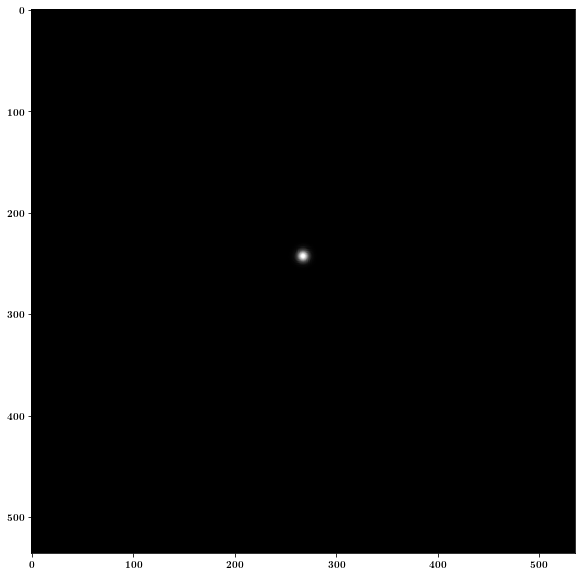

In [75]:
peak = find_peak_f_coordinates(flat_transformed)
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cutout, cmap='gray', interpolation='none')
plt.savefig('plots/projection1.png', dpi=300)

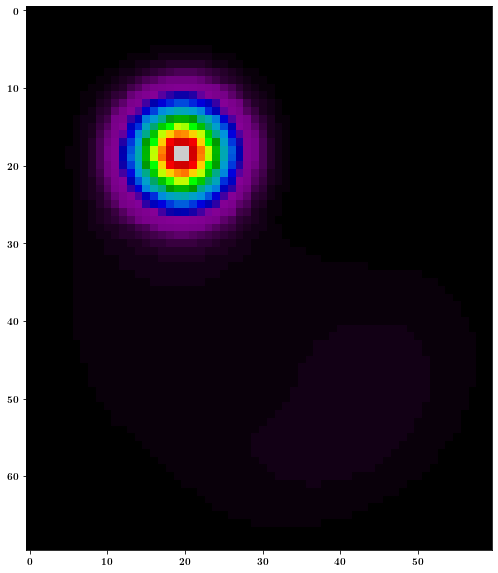

In [170]:
# https://stackoverflow.com/a/54571830/287954
def trim_array(arr, mask):
    bounding_box = tuple(
        slice(np.min(indexes), np.max(indexes) + 1)
        for indexes in np.where(mask))
    return arr[bounding_box]

def get_bbox(arr, mask):
    bounding_box = tuple((np.min(indexes), np.max(indexes) + 1)
        for indexes in np.where(mask))
    return bounding_box

t = trim_array(flat_transformed, flat_transformed != 0)
peak = find_peak_f_coordinates(t)
#cutout = slice_cutout(t, peak, axis=0)
projection = get_projection(t, axis=2)
fig, ax = plt.subplots(figsize=(10, 10))
# cmaps: nipy_spectral, gist_stern, gist_ncar, turbo
plt.imshow(projection, cmap='nipy_spectral', interpolation='none')

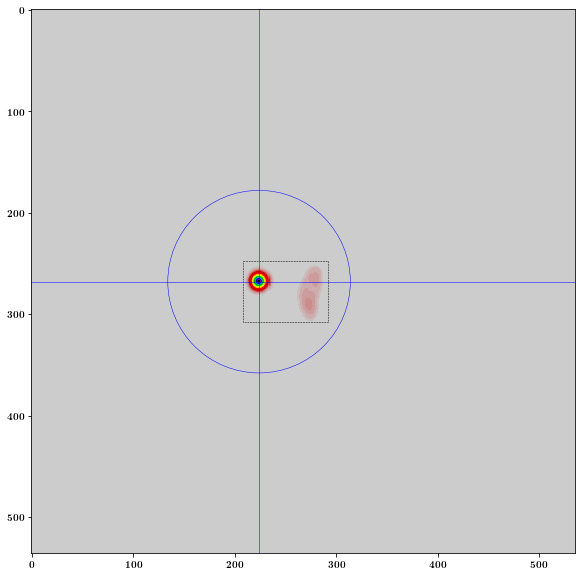

In [213]:
def plot_f_2d(f, ax=None, axis=1,
              pos=None, view='projection',
              crosshair=True, bbox=True, trim=False):
    if trim:
        f = trim_array(f, f != 0)

    if view == 'projection':
        imgdata = get_projection(f, axis=axis)
    elif view == 'slice':
        if pos is None:
            raise ValueError('pos must be specified for slice view')
        imgdata = slice_cutout(f, pos, axis=axis)
    else:
        raise ValueError(f'Unknown view {view}')

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(imgdata, cmap='nipy_spectral_r', interpolation='none')

    if crosshair:
        if pos is None:
            raise ValueError('pos must be specified for crosshair')
        # axis: 0=zy, 1=xz, 2=xy
        xy = [pos[i] for i in range(len(pos)) if i != axis]
        ax.axvline(x=xy[1], color='b', linestyle='-', linewidth=0.5)
        ax.axhline(y=xy[0], color='b', linestyle='-', linewidth=0.5)
        circ = mpl.patches.Circle((xy[1], xy[0]), 90,
                                  linewidth=0.5,
                                  edgecolor='b',
                                  facecolor='none')
        ax.add_patch(circ)

    if bbox and not trim:
        bbox = get_bbox(f, f != 0)
        bbox = [bbox[i] for i in range(len(bbox)) if i != axis]
        a = (bbox[1][0], bbox[0][0]) # rectangle anchor point
        w = bbox[1][1] - bbox[1][0] # rectangle width
        h = bbox[0][1] - bbox[0][0] # rectangle height
        rect = mpl.patches.Rectangle(a, w, h,
                                     linewidth=0.5,
                                     edgecolor='k',
                                     linestyle='--',
                                     facecolor='none')
        ax.add_patch(rect)

peak = find_peak_f_coordinates(flat_transformed)
plot_f_2d(flat_transformed, pos=peak, axis=0)
    

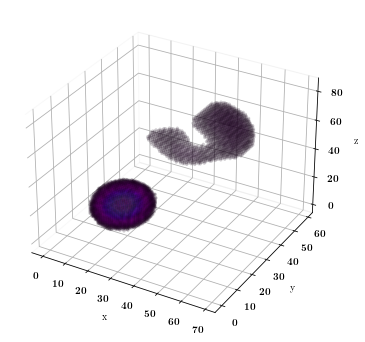

In [191]:
# https://stackoverflow.com/a/66939879/287954
def plot_f_3d(f, ax=None, threshold=0.01, intensity=10.0, trim=True):
    f = trim_array(f, f != 0)
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(projection="3d")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    mask = np.abs(f) > threshold
    idx = np.arange(int(np.prod(f.shape)))
    x, y, z = np.unravel_index(idx, f.shape)
    ax.scatter(x, y, z, c=f.flatten(), s=intensity * mask, edgecolor="face", alpha=0.2, marker="o", cmap="nipy_spectral", linewidth=0)
    ax.set(xlabel="x", ylabel="y", zlabel="z")
plot_f_3d(flat_transformed)

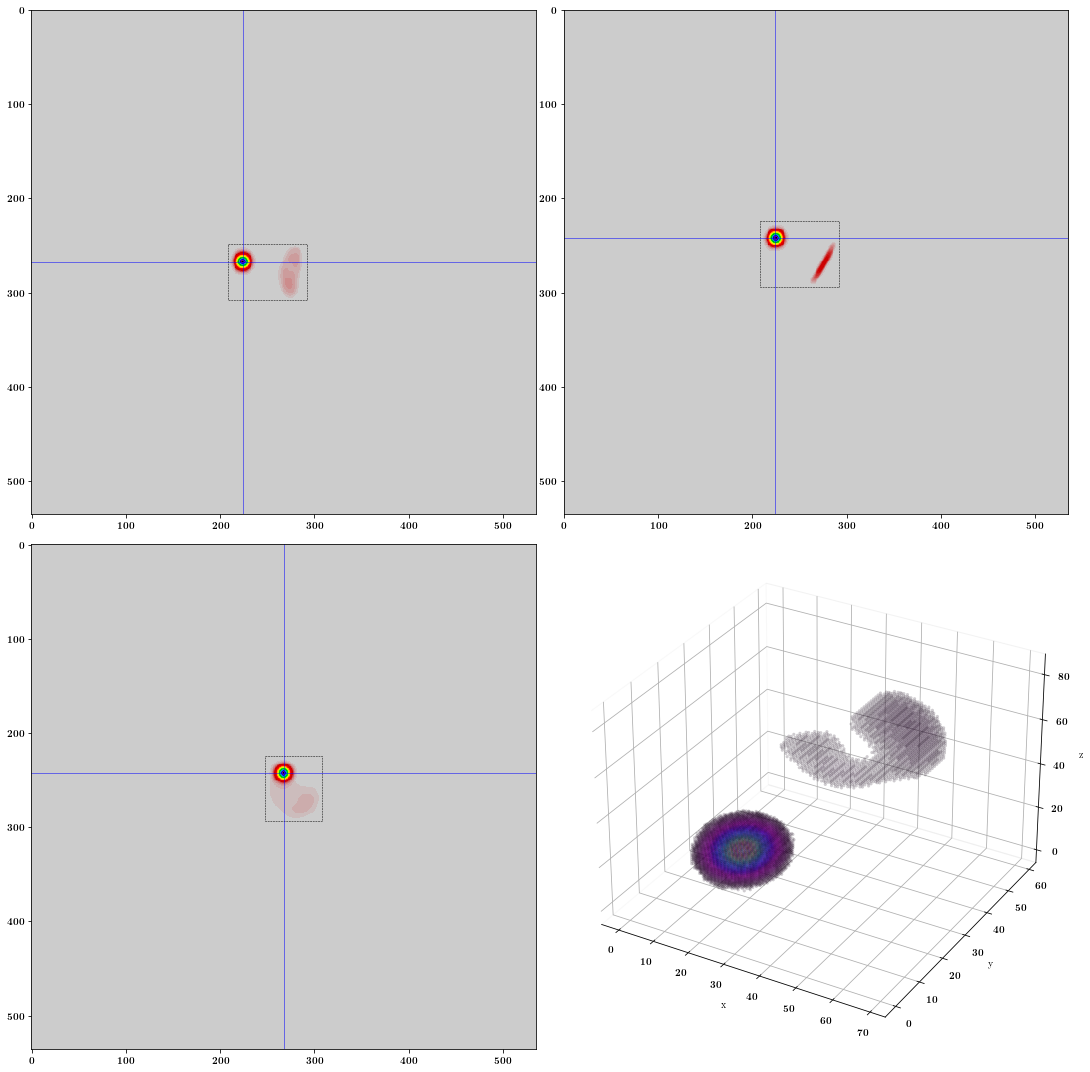

In [195]:
peak = find_peak_f_coordinates(flat_transformed)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plot_f_2d(flat_transformed, ax=ax[0][0], pos=peak, axis=0)
plot_f_2d(flat_transformed, ax=ax[0][1], pos=peak, axis=1)
plot_f_2d(flat_transformed, ax=ax[1][0], pos=peak, axis=2)
ax[1][1].remove()
ax[1][1] = fig.add_subplot(2,2,4,projection='3d')
plot_f_3d(flat_transformed, ax=ax[1][1])
plt.tight_layout()

In [127]:
b = get_bbox(flat_transformed, flat_transformed != 0)
print(b)

(slice(224, 294, None), slice(248, 308, None), slice(208, 292, None))
((224, 294), (248, 308), (208, 292))


In [67]:
#print(len(cutout[cutout < 0]))
#print(len(cutout))
#print(cutout)
#np.savetxt("plots/cutout.txt", cutout)
#print(cutout.max())
#cutout = np.log(cutout + 1)
#cutout = cutout / np.max(cutout)
#cutout = np.cbrt(cutout) # square root transform to enhance the more distant parts
#cutout = np.log(cutout)
#print(cutout)
#with np.errstate(divide='ignore'):
#    projection = np.log(projection)
#projection[np.isnan(projection)] = -np.inf

0
536
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [63]:
#projection
#plt.imshow(projection, cmap='gray', interpolation='none')

In [ ]:
len(data_filenames)

16

In [64]:
#projection

In [ ]:
cutout.max()

0.01943441487100201

In [ ]:
len(flat_transformed[flat_transformed > 0])

79580

In [ ]:
flat

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
np.min(flat)

-4.054952776951741e-20

In [ ]:
np.log(-1e-20)

C:\Users\makes\AppData\Local\Temp/ipykernel_4380/127735315.py:1: RuntimeWarning: invalid value encountered in log
  np.log(-1e-20)


nan

In [ ]:
print(cutout.max())

1.1339189628133272e-05
